# Mini Project on Salary Data Analysis Using PySpark

# DataSet: Tourism_Data.csv

# Source: https://data.telangana.gov.in/dataset/tourism-domestic-visitors-data

## **Dataset Insights**

The dataset contains information on **8,490 tourism records** across **80 districts**, capturing key attributes that influence tourism activity: **District, Month, Visitors, Year, and Season**. The dataset is complete, clean, and consistent, making it suitable for analyzing tourism patterns, seasonal trends, and visitor growth across years.

---

## **Visitor Distribution**

The number of visitors varies significantly across districts and months, reflecting seasonal demand and regional attractions.

* **Average visitors:** ~84,000 per record
* **Median visitors:** ~1,158 (indicating many smaller records and a few large spikes)
* **Maximum visitors:** Over **9.7 million**, representing major tourist hubs or large seasonal events.
  Visual analysis would likely show a **right-skewed distribution**, where most records have modest visitor counts, but a few districts experience very high spikes due to popular destinations or festivals.

---

## **Factors Affecting Tourist Visits**

Several factors in the dataset correlate strongly with visitor numbers:

* **District:** Popular districts (with heritage sites, natural attractions, or cities) receive substantially higher tourist counts than smaller or rural districts.
* **Month:** Visitor trends show seasonal variation, with peak months during holidays or favorable weather conditions.
* **Season:** Seasons like **Winter and Summer** attract the highest tourist flows, while **Monsoon** tends to have fewer visitors.
* **Year:** Year-over-year data (spanning 10 years) allows for tracking tourism growth trends and recovery patterns post events like pandemics or policy changes.

---

## **Tourism Composition and Trends**

* **District Diversity:** 80 districts allow for regional comparisons and identification of top-performing tourist destinations.
* **Seasonal Trends:** 4 distinct seasons (Winter, Summer, Monsoon, and Post-Monsoon) make it ideal for studying how weather impacts tourism.
* **Temporal Coverage:** Data spans **10 years**, providing insight into long-term tourism growth and fluctuations.
  This diversity makes the dataset excellent for tourism forecasting, regional analysis, and identifying factors that drive visitor behavior.

---

## **Key Visitor Patterns**

* **Visitors vs. Season:** Clear seasonal pattern — Winter and Summer months see a surge in visitors.
* **Visitors vs. District:** Major cities and heritage districts have significantly higher footfall.
* **Visitors vs. Year:** Gradual upward trend indicates tourism growth, though some years may show dips due to external factors.
* **Visitor Outliers:** A few records show exceptionally high visitor counts, representing famous attractions or state-level tourism events.

In [61]:
#1: Imports & SparkSession
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, to_date, month, when, count, avg, sum as _sum, desc, trim, regexp_replace
from pyspark.sql.types import *
import pandas as pd
import os, shutil
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("TelanganaTourism_Presentation") \
    .config("spark.driver.memory", "4g") \
    .master("local[*]") \
    .getOrCreate()

print('Spark session started:', spark)

Spark session started: <pyspark.sql.session.SparkSession object at 0x00000270FE1DA8D0>


In [62]:
#2: Load the dataset
import os
path = 'Tourism_data.csv'

sdf = spark.read.csv("Tourism_Data.csv", header=True, inferSchema=True)
sdf.printSchema()

print('Rows:', sdf.count(), 'Columns:', len(sdf.columns))

root
 |-- District: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Visitors: double (nullable = true)
 |-- Year: string (nullable = true)
 |-- Season: string (nullable = true)

Rows: 8489 Columns: 5


In [63]:
#3: View first 10 rows
print("=== First 10 rows of dataset ===")
sdf.show(10, truncate=False)

=== First 10 rows of dataset ===
+--------+---------+--------+----+-------+
|District|Month    |Visitors|Year|Season |
+--------+---------+--------+----+-------+
|Adilabad|January  |621850.0|2020|Monsoon|
|Adilabad|February |29421.0 |2020|Monsoon|
|Adilabad|March    |9430.0  |2020|Monsoon|
|Adilabad|June     |1909.0  |2020|Winter |
|Adilabad|July     |549.0   |2020|Winter |
|Adilabad|August   |654.0   |2020|Autumn |
|Adilabad|September|3978.0  |2020|Summer |
|Adilabad|October  |15128.0 |2020|Autumn |
|Adilabad|November |27525.0 |2020|Autumn |
|Adilabad|December |61403.0 |2020|Monsoon|
+--------+---------+--------+----+-------+
only showing top 10 rows


In [64]:
#4: Data cleaning & type conversions 
# Trim column names and values
for c in sdf.columns:
    sdf = sdf.withColumnRenamed(c, c.strip())

# Trim string columns
for c in ['District', 'Month', 'Season']:
    if c in sdf.columns:
        sdf = sdf.withColumn(c, trim(col(c)))

# Handle Visitors and Year safely
if 'Visitors' in sdf.columns:
    # Remove commas and non-numeric characters before casting
    sdf = sdf.withColumn('Visitors', regexp_replace(col('Visitors'), '[^0-9\\.]', ''))
    sdf = sdf.withColumn('Visitors', col('Visitors').cast('double'))

if 'Year' in sdf.columns:
    # Convert only if the value is 4 digits (like 2020, 2021, etc.)
    sdf = sdf.withColumn(
        'Year',
        when(col('Year').rlike('^[0-9]{4}$'), col('Year').cast('int')).otherwise(None)
    )

# Drop rows where Year or Visitors is NULL after cleanup
sdf = sdf.filter(col('Year').isNotNull() & col('Visitors').isNotNull())

print("Cleaned data successfully.")
print(f"Rows after cleaning: {sdf.count()}")
print("=== Schema of dataset ===")
sdf.printSchema()
sdf.show(5)

Cleaned data successfully.
Rows after cleaning: 8453
=== Schema of dataset ===
root
 |-- District: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Visitors: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Season: string (nullable = true)

+--------+--------+--------+----+-------+
|District|   Month|Visitors|Year| Season|
+--------+--------+--------+----+-------+
|Adilabad| January|621850.0|2020|Monsoon|
|Adilabad|February| 29421.0|2020|Monsoon|
|Adilabad|   March|  9430.0|2020|Monsoon|
|Adilabad|    June|  1909.0|2020| Winter|
|Adilabad|    July|   549.0|2020| Winter|
+--------+--------+--------+----+-------+
only showing top 5 rows


In [65]:
# Count total number of rows and columns
print("=== Total no.of rows ===")
print(sdf.count())
print("=== List of columns ===")
print(sdf.columns)

=== Total no.of rows ===
8453
=== List of columns ===
['District', 'Month', 'Visitors', 'Year', 'Season']


In [66]:
# Select specific columns
print("=== Print District and Visitors columns ===")
sdf.select("District", "Visitors").show(10)

=== Print District and Visitors columns ===
+--------+--------+
|District|Visitors|
+--------+--------+
|Adilabad|621850.0|
|Adilabad| 29421.0|
|Adilabad|  9430.0|
|Adilabad|  1909.0|
|Adilabad|   549.0|
|Adilabad|   654.0|
|Adilabad|  3978.0|
|Adilabad| 15128.0|
|Adilabad| 27525.0|
|Adilabad| 61403.0|
+--------+--------+
only showing top 10 rows


In [67]:
# Districts with Visitors > 50000
print("=== Print Districts with greater than 50000 Visitors ===")
sdf.filter(sdf.Visitors > 50000).show(10)

=== Print Districts with greater than 50000 Visitors ===
+--------------------+--------+---------+----+-------+
|            District|   Month| Visitors|Year| Season|
+--------------------+--------+---------+----+-------+
|            Adilabad| January| 621850.0|2020|Monsoon|
|            Adilabad|December|  61403.0|2020|Monsoon|
|Bhadradri Kothagudem| January| 269310.0|2020| Summer|
|Bhadradri Kothagudem|February| 238140.0|2020| Winter|
|Bhadradri Kothagudem|   March|  79871.0|2020| Autumn|
|Bhadradri Kothagudem|November|  76900.0|2020| Autumn|
|Bhadradri Kothagudem|December|  80842.0|2020| Winter|
|           Hyderabad| January|1157153.0|2020|Monsoon|
|           Hyderabad|February| 868641.0|2020| Autumn|
|           Hyderabad|   March| 321650.0|2020| Summer|
+--------------------+--------+---------+----+-------+
only showing top 10 rows


In [68]:
# Districts with Visitors > 50000 in the Season "Monsoon" 
print("\n=== Print Districts with Visitors in Monsoon Season ===")
sdf.filter((sdf.Season == "Monsoon") & (sdf.Visitors >= 50000 )).show(10)


=== Print Districts with Visitors in Monsoon Season ===
+----------------+--------+---------+----+-------+
|        District|   Month| Visitors|Year| Season|
+----------------+--------+---------+----+-------+
|        Adilabad| January| 621850.0|2020|Monsoon|
|        Adilabad|December|  61403.0|2020|Monsoon|
|       Hyderabad| January|1157153.0|2020|Monsoon|
|       Hyderabad|December| 442895.0|2020|Monsoon|
|         Jagtial| January| 340174.0|2020|Monsoon|
|         Jagtial|December| 155757.0|2020|Monsoon|
|Jogulamba Gadwal|    July|  88182.0|2020|Monsoon|
|Jogulamba Gadwal| October| 116753.0|2020|Monsoon|
|Jogulamba Gadwal|December| 184380.0|2020|Monsoon|
|         Khammam|February| 114417.0|2020|Monsoon|
+----------------+--------+---------+----+-------+
only showing top 10 rows


In [69]:
# Calculate Average, minimum and maximum Visitors
from pyspark.sql.functions import avg, min, max

print("=== Print average, minimum, maximum Visitors ===")
sdf.agg(
    avg("Visitors").alias("avg_Visitors"),
    min("Visitors").alias("min_Visitors"),
    max("Visitors").alias("max_Visitors")
).show()

=== Print average, minimum, maximum Visitors ===
+-----------------+------------+------------+
|     avg_Visitors|min_Visitors|max_Visitors|
+-----------------+------------+------------+
|84625.28266783636|         0.0|   9761776.0|
+-----------------+------------+------------+



In [70]:
#Calculate average Visitors by Districts
print("=== Print average Visitors by Districts ===")
df.groupBy("District").agg(avg("Visitors").alias("avg_Visitors")).show()

=== Print average Visitors by Districts ===
+--------------------+------------------+
|            District|      avg_Visitors|
+--------------------+------------------+
|         Wanaparthy |12162.397435897436|
| Yadadri Bhongir ??3|            2021.0|
| Yadadri Bhongir ??1|            2021.0|
|         Sangareddy |123935.38461538461|
|         Hanumakonda|         23127.325|
| Nalgonda & Suryapet|         15517.175|
|             Jagtial|105071.76041666667|
|        Nagarkurnool|      51123.046875|
|    Warangal (Rural)|5038.1407407407405|
|     RajanuaSircilla| 431090.1666666667|
|        Mahabubabad | 5283.908045977011|
| Yadadri Bhongir ??6|            2021.0|
|Bhadradri Kothagudem| 39778.55128205128|
| Yadadri Bhongir ??2|            2021.0|
|      YadadriBhongir|         630465.25|
|        Mababubnagar|50708.333333333336|
|              Mulugu|289503.29962546815|
|         Ranga Reddy| 84336.48909201707|
|            Medchal | 84336.48909201726|
| Yadadri Bhongir ??4|          

In [71]:
#5: Total visitors overall and by year (show table)
if 'Visitors' in sdf.columns:
    total_visitors = sdf.agg(_sum('Visitors').alias('Total_Visitors')).collect()[0]['Total_Visitors']
    print('Total visitors (sum):', int(total_visitors))
    visitors_by_year = sdf.groupBy('Year').agg(_sum('Visitors').alias('Visitors')).orderBy('Year')
    visitors_by_year.show()
else:
    print('Visitors column not found; cannot compute totals.')

Total visitors (sum): 715337514
+----+--------------------+
|Year|            Visitors|
+----+--------------------+
|2018| 9.631997047641698E7|
|2019| 8.759006441096906E7|
|2020|2.8717226850383914E8|
|2021|         6.4013074E7|
|2022|        1.21633652E8|
|2023|         5.8608485E7|
+----+--------------------+



,District,TotalVisitors
0,Mulugu,77297381.0
1,"Hyderabad, Ranga Reddy, Medchal & Vikarabad",61325331.0
2,Yadadri Bhongir,49265564.0
3,Rajanna Sircilla,44543745.0
4,Hyderabad,43239548.0
5,Nirmal,38298757.0
6,"Hyderabad, Ranga Reddy, Medchal -Malkajigiri, ...",37466478.0
7,Jagtial,31533891.0
8,Mahbubnagar,29107796.0
9,Sangareddy,25581557.0


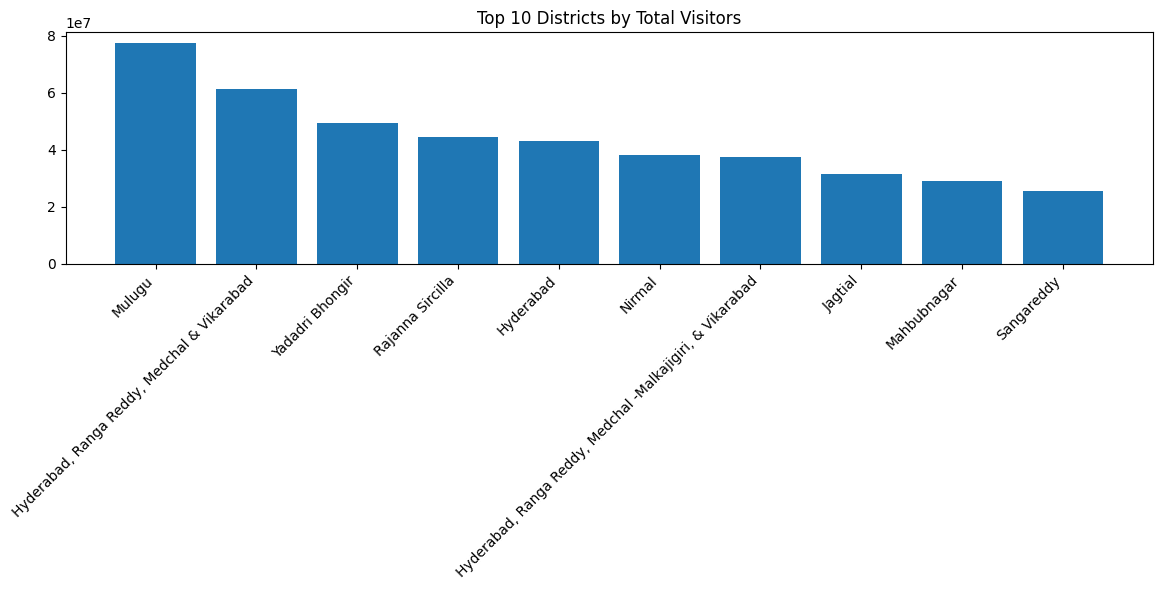

In [72]:
#6: Top 10 districts by visitors (bar chart)
if 'District' in sdf.columns and 'Visitors' in sdf.columns:
    district_totals = sdf.groupBy('District').agg(_sum('Visitors').alias('TotalVisitors'))
    top10 = district_totals.orderBy(desc('TotalVisitors')).limit(10)
    top10_pd = top10.toPandas()
    display(top10_pd)
    # plot and save
    plt.figure(figsize=(12,6))
    plt.bar(top10_pd['District'], top10_pd['TotalVisitors'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Districts by Total Visitors')
    plt.tight_layout()
    plt.savefig('top10_districts_pyspark.png')
    plt.show()
else:
    print('District or Visitors column missing.')


,Season,Visitors
0,Summer,1.959843e+08
1,Autumn,1.749197e+08
2,Winter,1.724415e+08
3,Monsoon,1.719920e+08


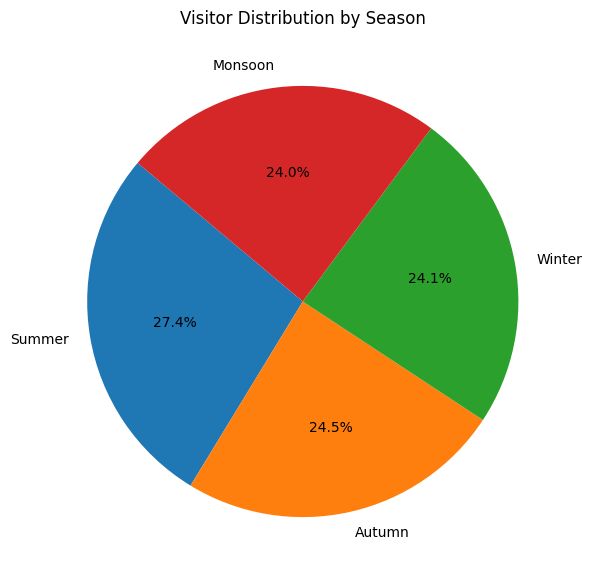

In [73]:
#7: Visitors by season (pie chart)
if 'Season' in sdf.columns and 'Visitors' in sdf.columns:
    season_agg = sdf.groupBy('Season').agg(_sum('Visitors').alias('Visitors')).orderBy(desc('Visitors'))
    season_pd = season_agg.toPandas()
    display(season_pd)
    plt.figure(figsize=(7,7))
    plt.pie(season_pd['Visitors'], labels=season_pd['Season'], autopct='%1.1f%%', startangle=140)
    plt.title('Visitor Distribution by Season')
    plt.savefig('season_distribution_pyspark.png')
    plt.show()
else:
    print('Season or Visitors column missing.')

Year,2018,2019,2020,2021,2022,2023
Month,,,,,,
January,1.652590e+07,1.120395e+07,4.999392e+07,6757870.0,13060660.0,5134879.0
February,1.892894e+07,6.878036e+06,7.224517e+07,8173968.0,24890002.0,6077531.0
March,8.766310e+06,7.246234e+06,2.576481e+07,8166888.0,12083696.0,4842193.0
April,6.075624e+06,6.223714e+06,1.113828e+07,3597134.0,7747942.0,4200698.0
May,6.291517e+06,5.783794e+06,1.105659e+07,415858.0,9197682.0,4984775.0


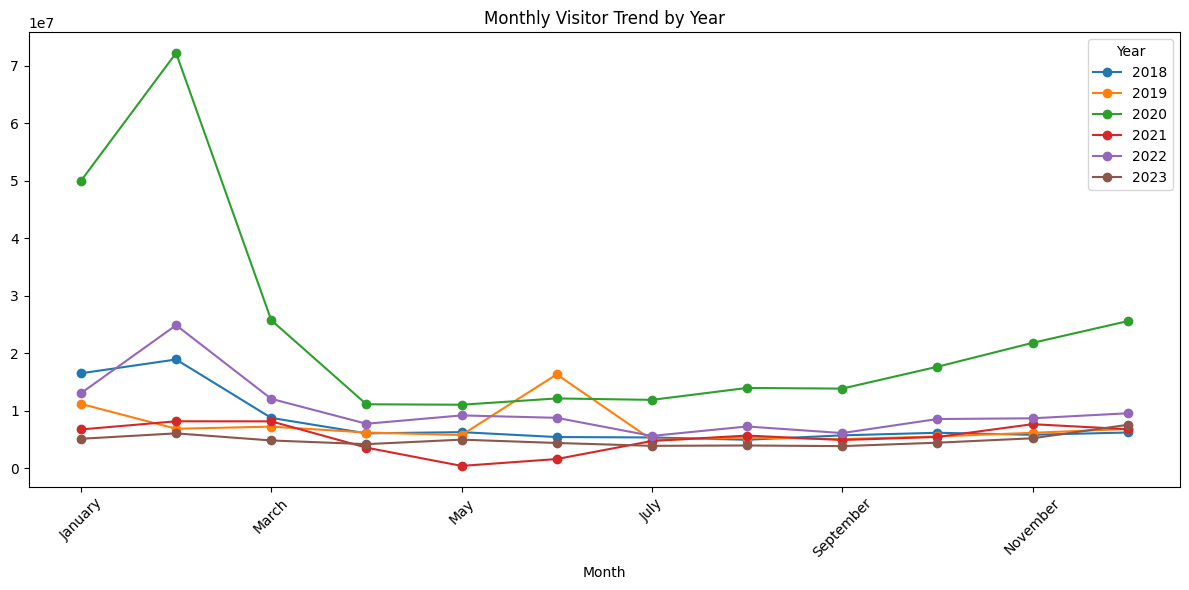

In [74]:
#8: Monthly trend by year (line chart)
if 'Month' in sdf.columns and 'Year' in sdf.columns and 'Visitors' in sdf.columns:
    # Ensure month ordering (January..December)
    month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
    sdf = sdf.withColumn('Month', col('Month'))
    monthly = sdf.groupBy('Year','Month').agg(_sum('Visitors').alias('Visitors'))
    monthly_pd = monthly.toPandas()
    # pivot for plotting
    monthly_pd['Month'] = pd.Categorical(monthly_pd['Month'], categories=month_order, ordered=True)
    pivot = monthly_pd.pivot(index='Month', columns='Year', values='Visitors').fillna(0)
    display(pivot.head())
    pivot.plot(figsize=(12,6), marker='o')
    plt.title('Monthly Visitor Trend by Year')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('monthly_trend_pyspark.png')
    plt.show()
else:
    print('Month/Year/Visitors columns required for monthly trend.')


Month,January,February,March,April,May,June,July,August,September,October,November,December
District,,,,,,,,,,,,
Mulugu,18882564.0,52064766.0,949015.0,595338.0,459456.0,459784.0,560231.0,579262.0,602818.0,605335.0,753946.0,784866.0
"Hyderabad, Ranga Reddy, Medchal & Vikarabad",5357454.0,4179324.0,4230918.0,2994756.0,4556901.0,4937517.0,3625116.0,4652286.0,4642002.0,7421823.0,6699294.0,8027940.0
Yadadri Bhongir,5928924.0,6204362.0,5580351.0,2128331.0,2660807.0,3305164.0,3606150.0,3701598.0,3339387.0,4224460.0,3974715.0,4611315.0
Rajanna Sircilla,15321245.0,4928950.0,5124317.0,1981936.0,2040083.0,1677813.0,1542589.0,1239419.0,1685914.0,1698842.0,3273814.0,4028823.0
Hyderabad,6951877.0,5004470.0,3402051.0,2632308.0,2495240.0,2858062.0,2564903.0,2712850.0,2533617.0,3950879.0,3562197.0,4571094.0
Nirmal,3880937.0,3831463.0,3939787.0,2546036.0,2248088.0,2727130.0,2829009.0,2993151.0,3030405.0,3306852.0,3502775.0,3463124.0
"Hyderabad, Ranga Reddy, Medchal -Malkajigiri, & Vikarabad",3624622.0,2595932.0,2309432.0,2717892.0,3593374.0,2849230.0,2445638.0,2719338.0,2613014.0,3854064.0,3350392.0,4793550.0
Jagtial,3705952.0,2684415.0,5315480.0,2837733.0,2786360.0,1889196.0,1620431.0,1881630.0,1646122.0,1602526.0,2537097.0,3026949.0
Mahbubnagar,1836712.0,6674093.0,2708451.0,1994169.0,1075723.0,1077369.0,2025969.0,2102237.0,2145232.0,1896639.0,3662456.0,1908746.0


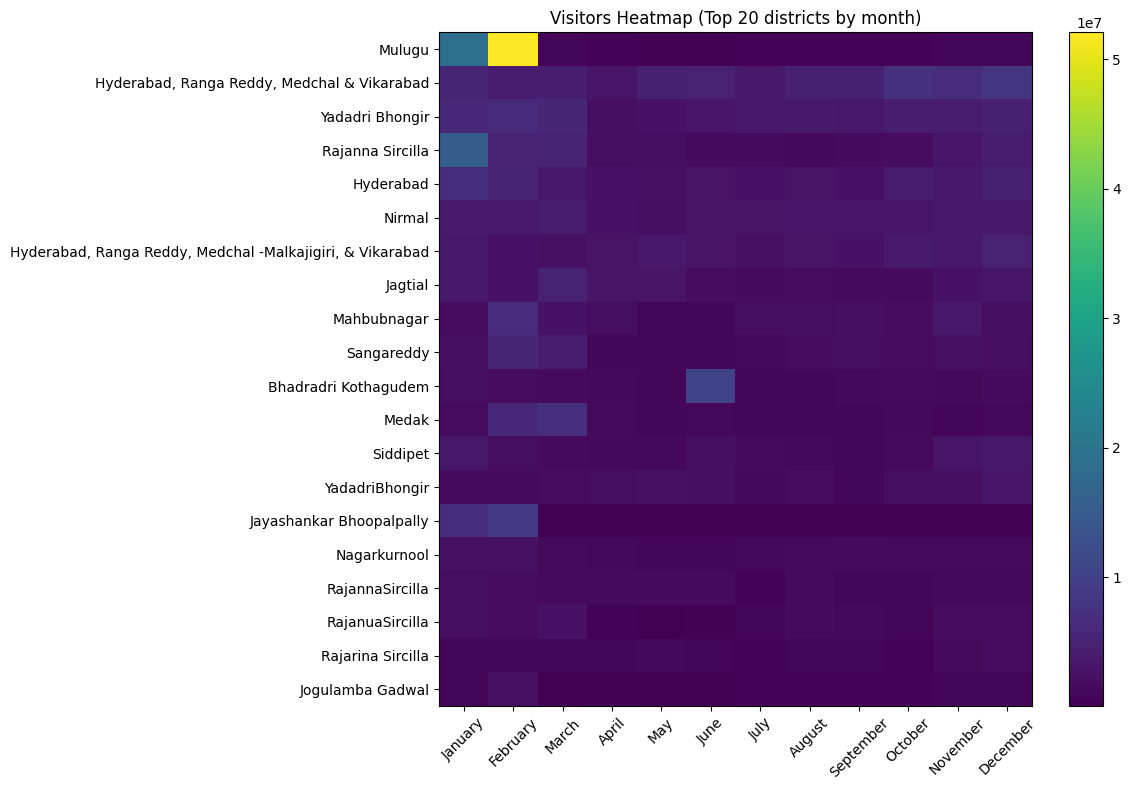

In [75]:
#9: District vs Month heatmap (top 20 districts)
if 'District' in sdf.columns and 'Month' in sdf.columns and 'Visitors' in sdf.columns:
    from pyspark.sql import Window
    district_tot = sdf.groupBy('District').agg(_sum('Visitors').alias('TotalVisitors'))
    top20 = district_tot.orderBy(desc('TotalVisitors')).limit(20).toPandas()['District'].tolist()
    heat_df = sdf.filter(col('District').isin(top20)).groupBy('District','Month').agg(_sum('Visitors').alias('Visitors'))
    heat_pd = heat_df.toPandas()
    heat_pivot = heat_pd.pivot(index='District', columns='Month', values='Visitors').fillna(0)
    # reorder rows and columns
    heat_pivot = heat_pivot.reindex(index=top20)
    heat_pivot = heat_pivot.reindex(columns=month_order, fill_value=0)
    display(heat_pivot)
    plt.figure(figsize=(12,8))
    plt.imshow(heat_pivot.values, aspect='auto')
    plt.yticks(range(len(heat_pivot.index)), heat_pivot.index)
    plt.xticks(range(len(heat_pivot.columns)), heat_pivot.columns, rotation=45)
    plt.title('Visitors Heatmap (Top 20 districts by month)')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig('district_month_heat_top20_pyspark.png')
    plt.show()
else:
    print('Columns needed: District, Month, Visitors')

